In [1]:
import numpy as np
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import preprocessing_modules as pm


2022-11-02 17:46:16.960225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 17:46:16.960254: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
enc=pm.ENCODE_data(cell_line='GM12878', assembly='hg19', res=100000 ,histones=True, total_rna=True, tf=False)

Selected cell line to predict: GM12878
Selected assembly: hg19
Selected signal type: signal p-value
Selected resolution:  100 kb


In [3]:
enc.download()

Number of replicas: 92


Process replicas: 100%|████████████████████████████████████████| 92/92 [03:20<00:00,  2.18s/it]


Experiments found in ENCODE for the selected cell line:
H2AFZ
H3K27ac
H3K27me3
H3K36me3
H3K4me1
H3K4me2
H3K4me3
H3K79me2
H3K9ac
H3K9me3
H4K20me1
RNA-seq-minus-total
RNA-seq-plus-total
Downoaded data stored at:  ENCODE_data/GM12878_hg19_100k


In [4]:
df_x,labels=enc.get_training_data(n_neighbor=2)


print(df_x.sample(20), len(labels))

Loading data from: ENCODE_data/GM12878_hg19_100k
There are 12 tracks: ['H2AFZ' 'H3K27ac' 'H3K27me3' 'H3K36me3' 'H3K4me1' 'H3K4me2' 'H3K4me3'
 'H3K79me2' 'H3K9ac' 'H3K9me3' 'H4K20me1' 'RNA']
Number of chromosomes:22

Normalizing data...
done!
        H2AFZ_0  H2AFZ_R1  H2AFZ_L1  H2AFZ_R2  H2AFZ_L2  H3K27ac_0  \
11662  0.500664  0.503508  0.516112  0.541646  0.495729   0.237601   
4749   0.425320  0.361256  0.619998  0.815490  0.770427   0.192567   
3014   0.448688  0.446029  0.463704  0.448076  0.453696   0.129565   
21873  0.457767  0.450380  0.398997  0.295619  0.328396   0.112484   
18447  0.222343  0.182845  1.000000  0.204900  0.335056   0.116432   
16179  0.625444  0.652620  0.587821  0.628404  0.616789   0.315772   
19674  0.364100  0.397652  1.000000  0.886456  0.397722   0.071524   
25844  0.218009  0.253138  0.277181  0.292911  0.228861   0.049706   
27999  0.383064  0.493947  0.617620  0.572319  0.489432   0.239335   
7591   0.783371  0.703609  1.000000  0.621847  0.560997   

In [4]:
sum(enc.get_chrm_size())

30376

In [4]:
np.unique(labels)

array([0., 1.])

In [4]:
df.sample(10)

,RNA_0,RNA_R1,RNA_L1,RNA_R2,RNA_L2,labels
14302,0.114322,0.205089,0.122284,0.204626,0.253821,None
37119,0.060037,0.039596,0.084529,0.058316,0.011399,None
51972,0.018984,0.037174,0.015544,0.03192,0.011544,None
19515,0.347008,0.254549,0.215219,0.201838,0.442038,None
52105,0.919212,0.836655,1.0,0.362088,0.49183,None
22407,0.800614,1.0,1.0,0.526874,0.712088,None
42583,0.678164,1.0,0.534944,1.0,0.484826,None
46592,0.077914,0.092402,0.098474,0.244233,0.054517,None
8587,0.092136,0.078098,0.081935,0.24515,0.084996,None
43490,0.051674,0.0,0.057645,0.0,0.002545,None


In [37]:
features_all = df.columns.to_numpy()[:-1]
# print(features_all)

data = df.to_numpy()
x_pre, y_pre = data[:,:-1], data[:,-1]


print(x_pre.shape, y_pre.shape, features_all.shape)

(52452, 760) (52452,) (760,)


In [28]:
print(df[features_all[198]].to_numpy())

print(x_pre[:, 198])

[0.53900784 0.9540162  0.3047727  ... 0.78025514 0.7082865  0.7330572 ]
[0.53900784 0.9540162  0.3047727  ... 0.78025514 0.7082865  0.7330572 ]


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x.to_numpy(), labels, test_size=0.25, random_state=1223)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(19669, 60) (19669,) (6557, 60) (6557,)


In [24]:
learning_rate = 0.001
dropout_rate = 0.2
num_epochs = 40
batch_size = 128
num_features=df_x.shape[1]
num_classes=2

In [15]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [16]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [17]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [18]:
def create_baseline_model(num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    
    x = create_ffn([32,32], dropout_rate, name=f"ffn_block1")(inputs)
    # x = create_ffn([64], dropout_rate, name=f"ffn_block2")(x)
    for block_ndx in range(2):
        x1 = create_ffn([32,32], dropout_rate, name=f"ffn_block{block_ndx+3}")(x)
        x = layers.Add(name=f"skip_connection{block_ndx+1}")([x, x1])

    x = create_ffn([16], dropout_rate, name=f"ffn_block{block_ndx+4}")(x)
    
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


In [42]:
baseline_model = create_baseline_model(num_classes, dropout_rate)

baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           3376        ['input_features[0][0]']         
                                                                                                  
 ffn_block3 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection1 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block3[0][0]']      

In [43]:
# inputs = layers.Input(shape=(num_features,), name="input_features")
# test=create_ffn(hidden_units,dropout_rate, name=f"ffn_block1")#(inputs)

# y=test(X_train)

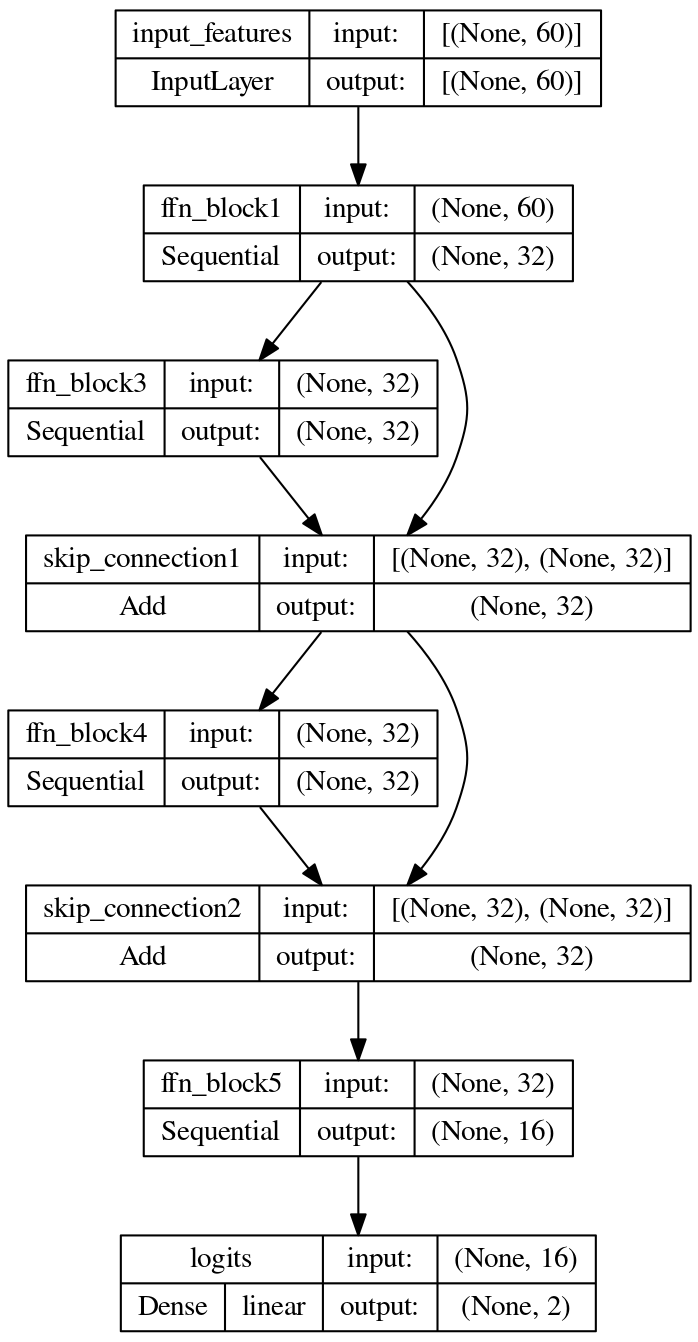

In [44]:
keras.utils.plot_model(baseline_model, to_file='model.png', show_shapes=True, dpi=150, show_layer_names=True, show_layer_activations=True, rankdir='TB')

In [45]:
history = run_experiment(baseline_model, X_train, Y_train)


Epoch 1/40
131/131 [==============================] - 3s 8ms/step - loss: 0.4273 - accuracy: 0.8107 - val_loss: 0.3604 - val_accuracy: 0.8417
Epoch 2/40
131/131 [==============================] - 1s 6ms/step - loss: 0.3186 - accuracy: 0.8698 - val_loss: 0.2935 - val_accuracy: 0.8814
Epoch 3/40
131/131 [==============================] - 1s 6ms/step - loss: 0.2983 - accuracy: 0.8750 - val_loss: 0.2618 - val_accuracy: 0.8912
Epoch 4/40
131/131 [==============================] - 1s 7ms/step - loss: 0.2865 - accuracy: 0.8794 - val_loss: 0.2567 - val_accuracy: 0.8926
Epoch 5/40
131/131 [==============================] - 1s 6ms/step - loss: 0.2823 - accuracy: 0.8794 - val_loss: 0.2532 - val_accuracy: 0.8960
Epoch 6/40
131/131 [==============================] - 1s 6ms/step - loss: 0.2757 - accuracy: 0.8814 - val_loss: 0.2490 - val_accuracy: 0.8970
Epoch 7/40
131/131 [==============================] - 1s 6ms/step - loss: 0.2777 - accuracy: 0.8819 - val_loss: 0.2470 - val_accuracy: 0.8973
Epoch 

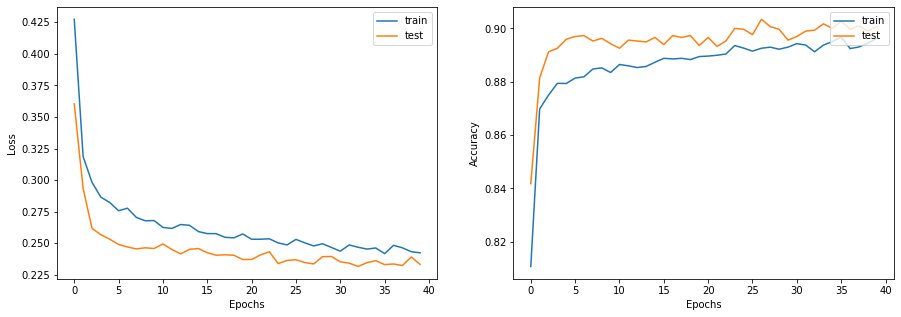

In [46]:
display_learning_curves(history)

In [49]:
v=baseline_model.predict(X_test)

print(Y_test, np.argmax(v, axis=1))

205/205 [==============================] - 0s 2ms/step
[1. 0. 1. ... 1. 0. 0.] [1 0 1 ... 1 0 0]


In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test, baseline_model.predict(X_test))

205/205 [==============================] - 0s 927us/step


ValueError: y should be a 1d array, got an array of shape (6557, 2) instead.

In [16]:
inputs = keras.Input(shape=X_train.shape[1])

# x1 = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(128, activation="relu",bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu", bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.add([x,x1])
# x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(np.unique(Y_train)), activation='relu')(x)

# del model
model = keras.Model(name="Predict-Chromatin-Types", inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=["accuracy"],
)

Model: "Predict-Chromatin-Types"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                384       
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 17,285
Trainable params: 17,2

In [17]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=60, validation_split=0.2)

Epoch 1/60
  1/246 [..............................] - ETA: 1:13 - loss: 0.8607 - accuracy: 0.1719

2022-11-02 03:06:05.454435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2102

2022-11-02 03:06:08.126990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 3s 12ms/step - loss: 0.4521 - accuracy: 0.2102 - val_loss: 0.3746 - val_accuracy: 0.2214
Epoch 2/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3903 - accuracy: 0.2155 - val_loss: 0.3842 - val_accuracy: 0.2201
Epoch 3/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3853 - accuracy: 0.2151 - val_loss: 0.3798 - val_accuracy: 0.2171
Epoch 4/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3801 - accuracy: 0.2201 - val_loss: 0.3680 - val_accuracy: 0.2199
Epoch 5/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3789 - accuracy: 0.2151 - val_loss: 0.3613 - val_accuracy: 0.2239
Epoch 6/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3725 - accuracy: 0.2199 - val_loss: 0.3697 - val_accuracy: 0.2194
Epoch 7/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3745 - accuracy: 0.2158 - val_loss: 0.3816 - val_accuracy: 0.2145
Epoch 8/60

KeyboardInterrupt: 

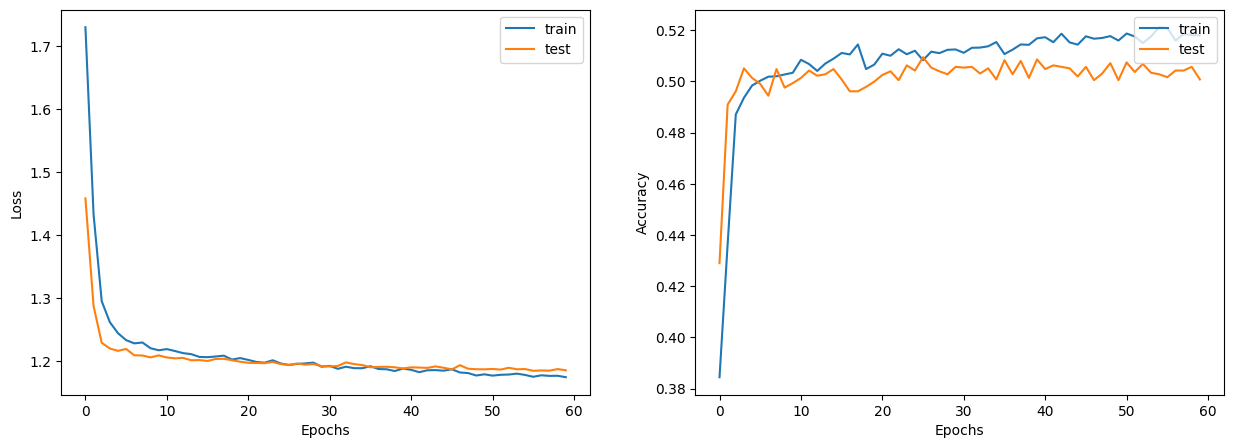

In [20]:
display_learning_curves(history)

In [ ]:
print(Y_test.shape, X_test.shape)
type_test={}

for val in np.unique(Y_test):
    ind = np.where(Y_test==val)[0]
    X_type=X_test[ind,:]
    Y_type=Y_test[ind]
    name=list(map(data.int_to_type.get, [val]))[0]

    print(name, Y_type.shape, X_type.shape)
    type_test[name] = (X_type,Y_type)

print(type_test.keys())


for key in type_test.keys():
    print("Type: ", key)
    test_scores = model.evaluate(type_test[key][0], type_test[key][1], verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])